# TAMSAT Pertinence Analysis

> T

In [ ]:
#| default_exp tamsat

In [ ]:
#| hide
from nbdev.showdoc import *

/home/i/Documentos/1_Proyectos/ombs_senegal/.venv/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [ ]:
#| export
from pathlib import Path
import xarray as xr
import geopandas as gpd

from ombs_senegal.region import get_region_mask

In [ ]:
DATA = Path("../../data")

In [ ]:
tamsat = xr.open_dataset(DATA/"01-tamsatDaily.v3.1-20100101-20250531-20250603_-16.85_-6.05_10.15_18.95.nc")

In [ ]:
roi_gdf = gpd.read_file(DATA/"point_ajustement/sub_poly.shp")
mask = get_region_mask(tamsat, roi_gdf)

<matplotlib.collections.QuadMesh>

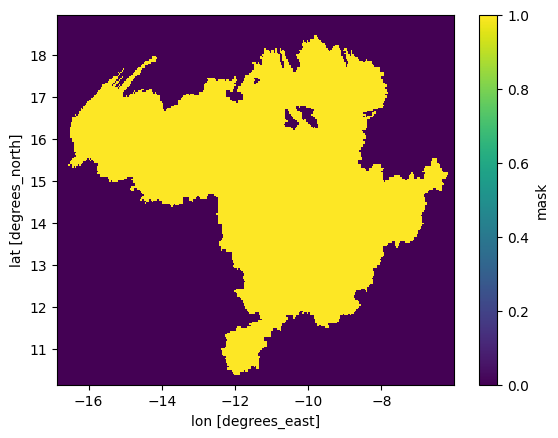

In [ ]:
mask.plot()

In [ ]:
roi_tamsat = tamsat.where(mask)

In [ ]:
roi_tamsat = roi_tamsat.sel(time=slice(None, "2024-12-31"))

[<matplotlib.lines.Line2D>]

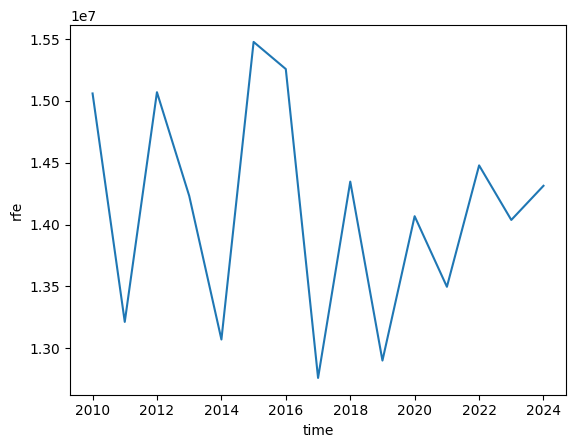

In [ ]:
daily_total = roi_tamsat.sum(["lat", "lon"])
yearly_total = daily_total.resample(time="YS").sum()
yearly_total["rfe"].plot()

In [ ]:
!pip install -q hvplot

In [ ]:
import hvplot.pandas
import pandas as pd

In [ ]:
df = pd.read_csv(
    DATA/'data_cumul.csv', 
    sep=';', 
    usecols=['time', 'débit_insitu'], 
    index_col='time',
    converters={"time": pd.to_datetime}
    )

In [ ]:
combined_df = pd.merge(df, daily_total["rfe"].to_dataframe(), left_index=True, right_index=True)
combined_df.head()

,débit_insitu,rfe
time,,
2010-01-01,84.410004,0.000000
2010-01-02,81.690002,0.000000
2010-01-03,78.720001,0.000000
2010-01-04,76.400002,114.599998
2010-01-05,74.910004,0.000000


In [ ]:
yearly_df = combined_df.resample("YS").sum()

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Débit vs Rainfall')

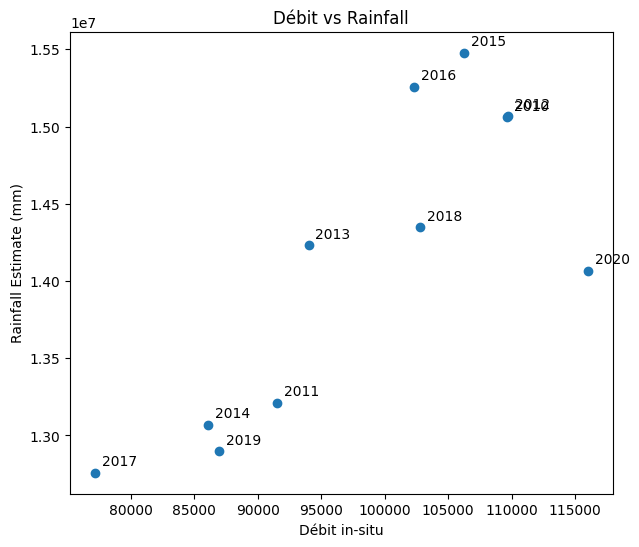

In [ ]:
plt.figure(figsize=(7,6))
plt.scatter(yearly_df['débit_insitu'], yearly_df['rfe'])

# Add year labels to each point
for idx, row in yearly_df.iterrows():
    plt.annotate(idx.year, 
                (row['débit_insitu'], row['rfe']),
                xytext=(5,5), 
                textcoords='offset points')

plt.xlabel('Débit in-situ')
plt.ylabel('Rainfall Estimate (mm)')
plt.title('Débit vs Rainfall')

In [ ]:
# Apply rolling mean to smooth the rainfall peaks while preserving the débit data
window_size = 10  # Adjust window size as needed for desired smoothing
smoothed_df = combined_df.copy()
smoothed_df['rfe'] = smoothed_df['rfe'].rolling(window=window_size, center=True).mean()

# Fill NaN values at edges caused by rolling mean
smoothed_df['rfe'] = smoothed_df['rfe'].fillna(method='bfill').fillna(method='ffill')

normalized_df = (smoothed_df - smoothed_df.min()) / (smoothed_df.max() - smoothed_df.min())

normalized_df.hvplot.line()

/tmp/ipykernel_807/294619058.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_df['rfe'] = smoothed_df['rfe'].fillna(method='bfill').fillna(method='ffill')


:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()